In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

import zipfile
import os

In [ ]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 100

# Model Name
MODEL_NAME = 'Handwritten-OCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)


In [ ]:
# zip_folder = 'drive/MyDrive/Text Recognition'
os.listdir()

['.config',
 '.ipynb_checkpoints',
 'validation_v2.zip',
 'drive',
 'written_name_validation.csv',
 'written_name_train.csv',
 'test.zip',
 'train_v2 (1).zip',
 'validation',
 'written_name_test.csv',
 'train_v2.zip',
 'test',
 'sample_data']

In [ ]:
def unzip_file(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()  # Extracts in the current working directory

# Now call the function for each zip file
# unzip_file('train.zip')
unzip_file('validation_v2.zip')
unzip_file('test.zip')

# for filename in os.listdir(zip_folder):
#     if filename.endswith('.zip'):
#         zip_path = os.path.join(zip_folder, filename)
#         print(f'Unzipping: {zip_path}')

#         # Extract the contents back into the same folder
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(zip_folder)  # Unzip into the same folder

In [ ]:
unzip_file('train.zip')

In [ ]:
test_csv = pd.read_csv('written_name_test.csv')[:TEST_SIZE]
train_csv = pd.read_csv('written_name_train.csv')[:TRAIN_SIZE]
valid_csv = pd.read_csv('written_name_validation.csv')[:VALID_SIZE]

In [ ]:
print(train_csv.shape)
print(valid_csv.shape)
print(test_csv.shape)

(16000, 2)
(8000, 2)
(1600, 2)


In [ ]:
# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [ ]:
# # Train CSV
# train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# # Validation CSV
# valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# # Test CSV
# test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

NameError: name 'train_csv_path' is not defined

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
# Get all train labels
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]
train_labels[:10]

['BALTHAZAR',
 'SIMON',
 'BENES',
 'LA LOVE',
 'DAPHNE',
 'LUCIE',
 'NASSIM',
 'ASSRAOUI',
 'LAVIAN',
 'MAEVA']

In [ ]:
# Unique characters
unique_chars = set(char for word in train_labels for char in word) #set automatically removes duplicates
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 41
Unique Characters : 
{' ', 'W', 'c', 'e', 'Y', 'E', '-', 'o', 'L', 'O', 's', 'C', 'H', 'J', "'", 'X', 'D', 'u', 'l', 'G', 'n', 'Z', 'K', 'I', 'N', 't', 'B', 'P', 'r', 'R', 'F', 'S', 'V', 'a', 'Q', 'A', 'T', 'p', 'U', 'M', 'y'}


In [ ]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 24


In [ ]:
train_image_dir = 'train'
valid_image_dir = 'validation'
test_image_dir  = 'test'

In [ ]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,train/TRAIN_00001.jpg,BALTHAZAR
1,train/TRAIN_00002.jpg,SIMON
2,train/TRAIN_00003.jpg,BENES
3,train/TRAIN_00004.jpg,LA LOVE
4,train/TRAIN_00005.jpg,DAPHNE


In [ ]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [ ]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''
  # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    return image

In [ ]:
def encode_single_sample(image_path : str, label : str):
    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

In [ ]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 16000
Validation Data Size : 8000
Testing Data Size    : 1600


In [ ]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

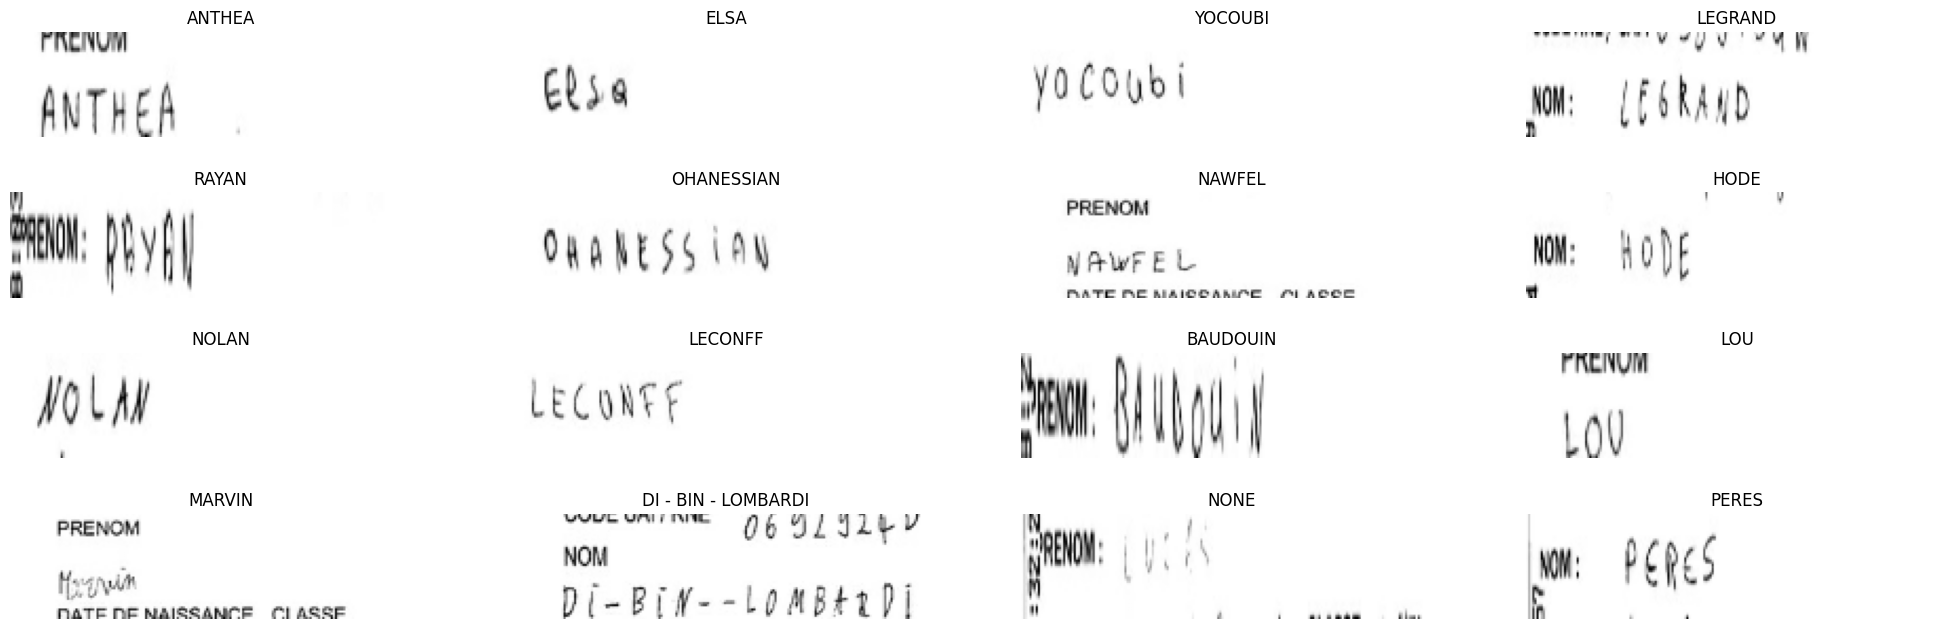

In [ ]:
show_images(data=train_ds, cmap='gray')

In [ ]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

In [ ]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

In [ ]:
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

In [ ]:
# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

In [ ]:

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model_2 = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

# Compile
ocr_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 53ms/step - loss: 355.1009 - val_loss: 306.8143
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - loss: 307.9164 - val_loss: 299.1620
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - loss: 298.1475 - val_loss: 294.0182
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - loss: 293.3382 - val_loss: 294.8560
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 60ms/step - loss: 281.4906 - val_loss: 254.7835
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 50ms/step - loss: 238.5098 - val_loss: 147.9870
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - loss: 122.8893 - val_loss: 75.1805
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - loss: 71.5374 - val_loss: 56.0768
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - loss: 52.7836 - val_loss: 49.0927
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - loss: 44.5328 - val_loss: 44.8109
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/ste

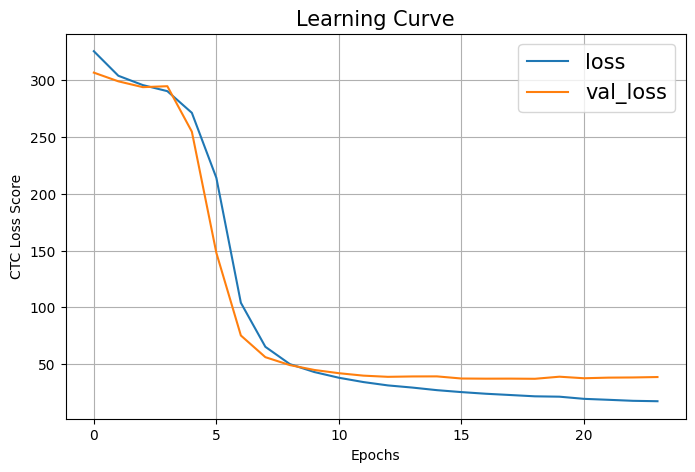

In [ ]:

# Train
history_2 = ocr_model_2.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Learning Curve
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [ ]:
for i, layer in enumerate(ocr_model_2.layers):
    print(i, layer.name)

0 image
1 conv2d
2 conv2d_1
3 max_pooling2d
4 conv2d_2
5 conv2d_3
6 max_pooling2d_1
7 reshape
8 dense
9 dense_1
10 dropout
11 bidirectional
12 bidirectional_1
13 label
14 dense_2
15 ctc_layer


In [ ]:
inference_model = keras.Model(
    inputs=ocr_model_2.input[0],  # Take the image input (index 0)
    outputs=ocr_model_2.get_layer("dense_2").output  # Final softmax output
)


In [ ]:
inference_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 50, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 25, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 1536)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 64)         │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 128)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 512)        │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50, 43)         │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,523 (6.35 MB)

 Trainable params: 1,664,523 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def decode_pred(pred_label):
  # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts


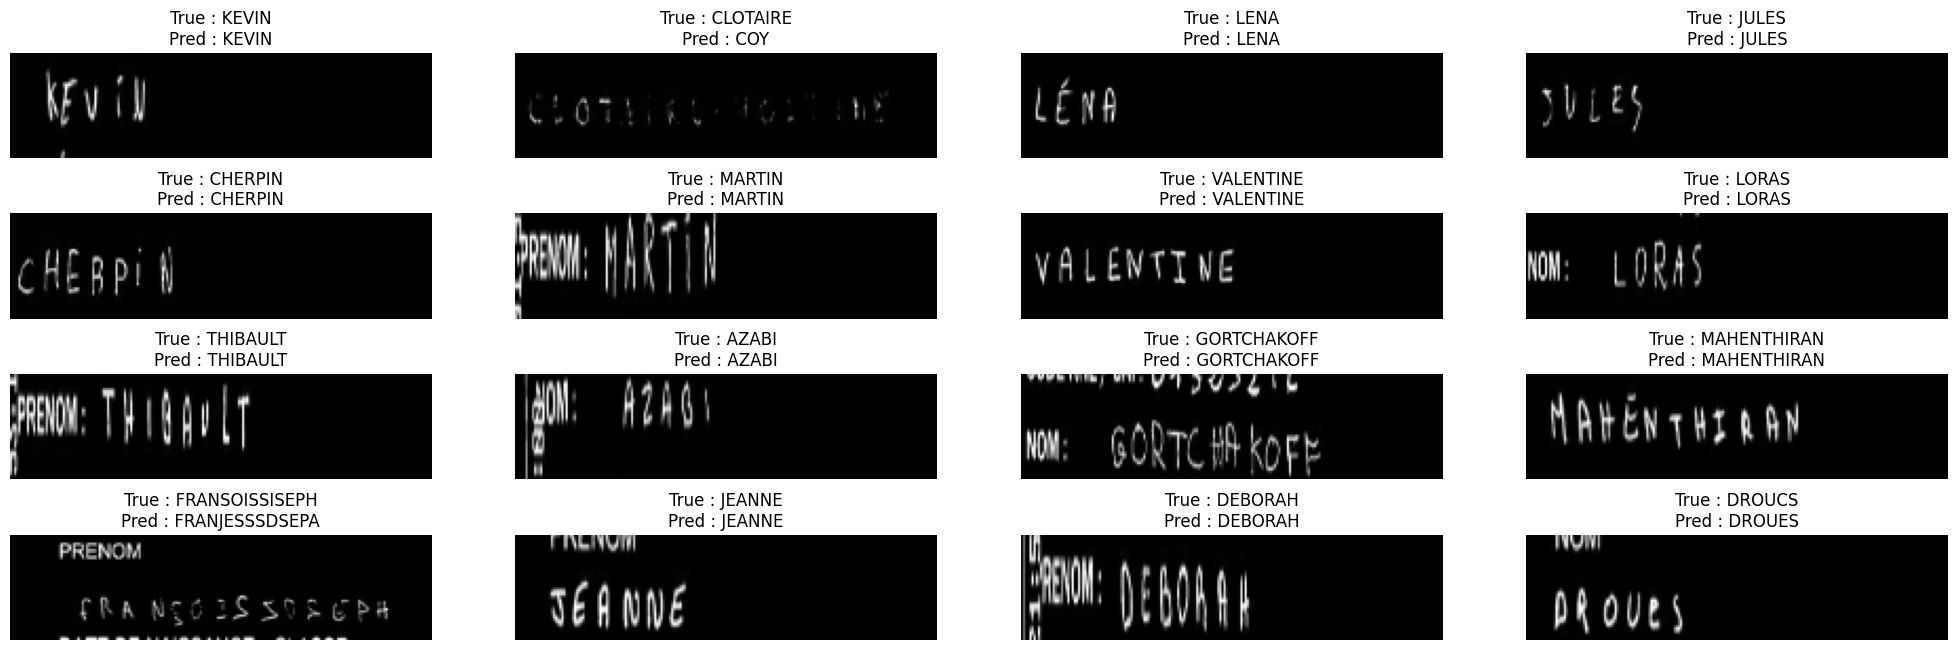

In [ ]:
show_images(data=test_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

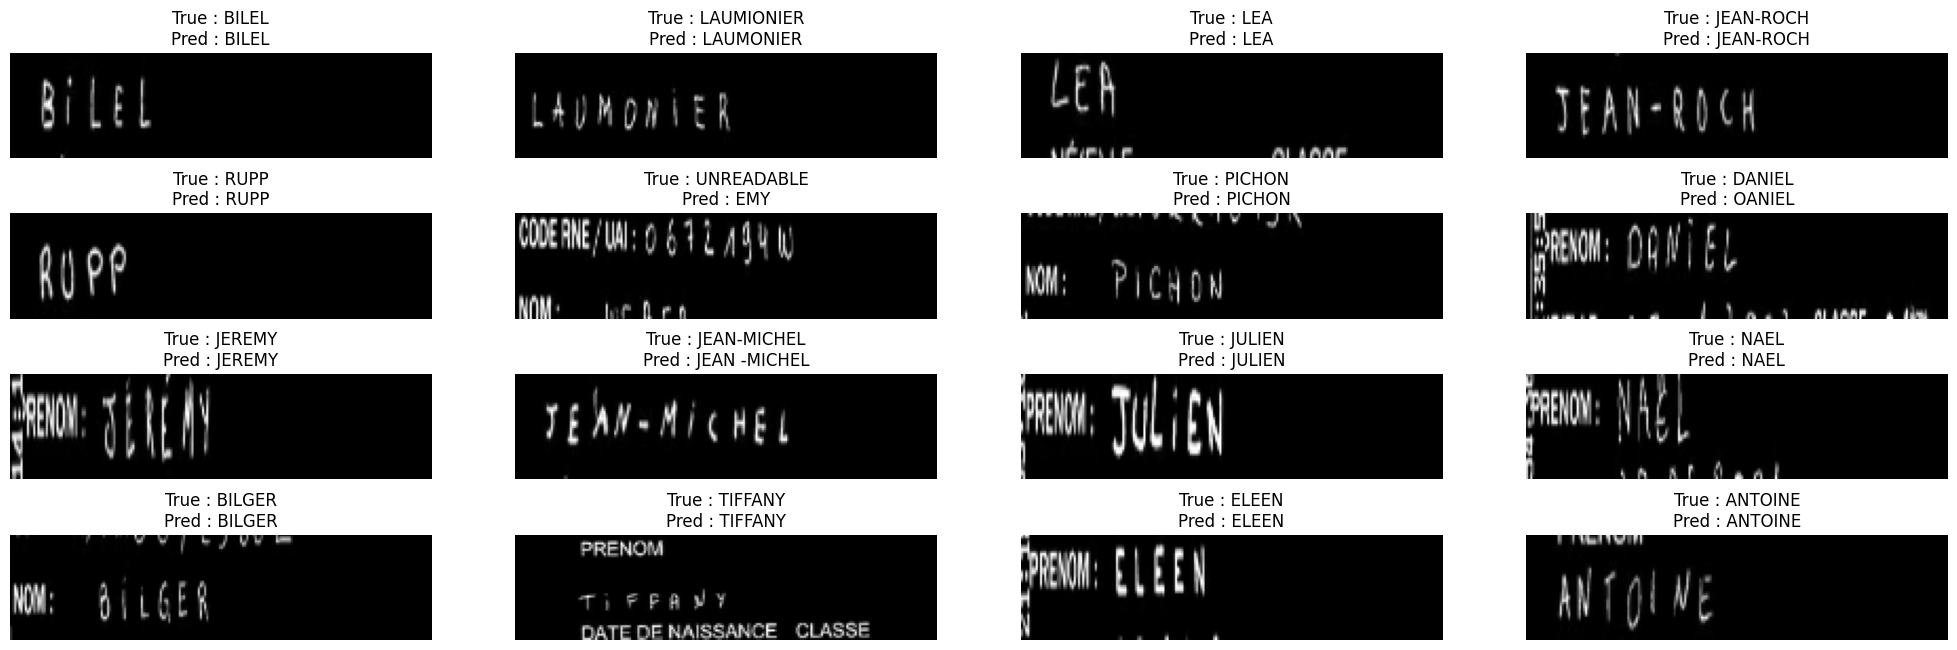

In [ ]:
show_images(data=valid_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')


In [ ]:
ocr_model_2.save("ocr_model.h5")

In [ ]:
def calculate_accuracy(model, dataset, decode_pred):
    total = 0
    correct = 0

    for batch in dataset:
        images, labels = batch['image'], batch['label']
        preds = model.predict(images)
        pred_texts = decode_pred(preds)

        for pred_text, label in zip(pred_texts, labels.numpy()):
            # Decode true labels
            true_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
            true_text = true_text.replace('[UNK]', " ").strip()

            if pred_text == true_text:
                correct += 1
            total += 1

    accuracy = correct / total
    return accuracy

# Calculate Accuracy on Validation set
val_accuracy = calculate_accuracy(inference_model, valid_ds, decode_pred)
print(f"Validation Accuracy: {val_accuracy:.2%}")
#71.20

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

In [ ]:
def calculate_wa(model, dataset, decode_pred):
    correct_words = 0
    total_words = 0

    for batch in dataset:
        images, labels = batch['image'], batch['label']
        preds = model.predict(images)
        pred_texts = decode_pred(preds)

        for pred_text, label in zip(pred_texts, labels.numpy()):
            # Decode true labels
            true_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
            true_text = true_text.replace('[UNK]', " ").strip()

            # Compare by exact match (word-level)
            if pred_text == true_text:
                correct_words += 1
            total_words += 1

    wa = correct_words / total_words
    return wa

# Calculate WA on Validation set
val_wa = calculate_wa(inference_model, valid_ds, decode_pred)
print(f"Validation Word Accuracy: {val_wa:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━

In [ ]:
for image, true_label in validation_df.take(1):  # Take just one batch for simplicity
    predictions = inference_model.predict(image)

    # Decode the predictions
    decoded_preds = decode_pred(predictions)

    # Loop through the batch and display images with incorrect predictions
    for i in range(len(decoded_preds)):
        predicted_text = decoded_preds[i]
        actual_text = true_label[i].numpy().decode('utf-8')  # Assuming true labels are in UTF-8 format

        # Compare predicted text with actual text
        if predicted_text != actual_text:
            # Display the image with the incorrect prediction and the actual label
            plt.figure(figsize=(5, 5))
            plt.imshow(image[i, :, :, 0], cmap='gray')  # Assuming images are in grayscale
            plt.title(f'Pred: {predicted_text}\nActual: {actual_text}')
            plt.axis('off')
            plt.show()

TypeError: len() of unsized object

In [ ]:
def show_images(data, GRID=[4, 4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Extract one batch of data
    data_iter = iter(data)
    data_batch = next(data_iter)

    # Extract images and labels from the batch
    images, labels = data_batch['image'], data_batch['label']

    # Check the type of images and labels
    print(f"Type of images: {type(images)}")
    print(f"Type of labels: {type(labels)}")

    # Iterate over the batch
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1, 0, 2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()


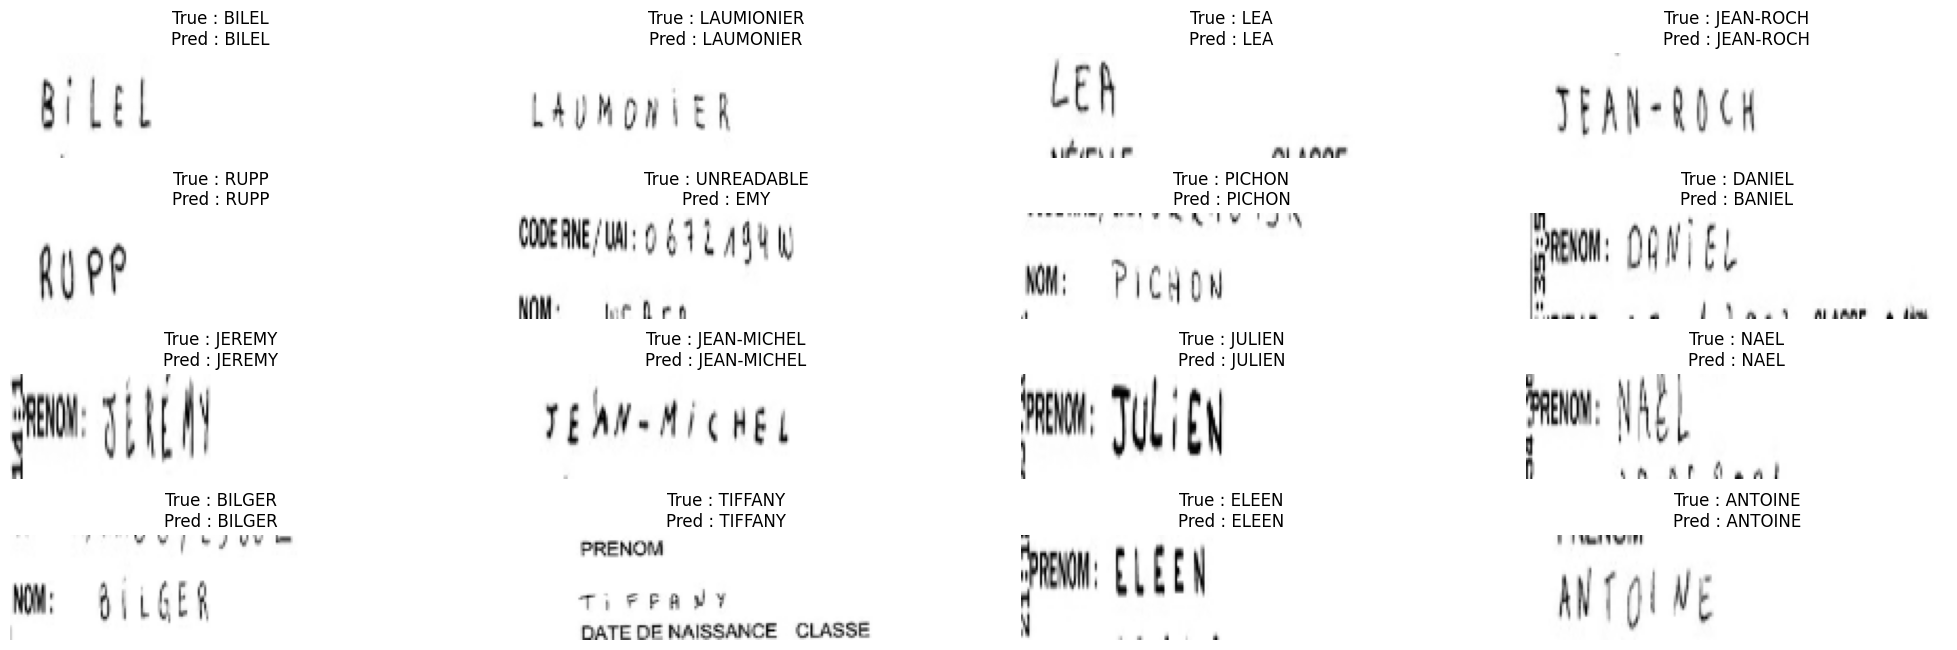

In [ ]:
show_images(data=valid_ds, GRID=[4, 4], FIGSIZE=(25, 8), cmap='binary_r', model=inference_model, decode_pred=decode_pred)


In [ ]:
# import numpy as np
# import editdistance

# def calculate_cer(predictions, labels):
#     total_edits = 0
#     total_chars = 0

#     for pred, label in zip(predictions, labels):
#         # Calculate edit distance (Levenshtein distance)
#         edits = editdistance.eval(pred, label)
#         total_edits += edits
#         total_chars += len(label)

#     cer = total_edits / total_chars
#     return cer

# # For one batch
# predictions = [decode_pred(inference_model.predict(image))[0] for image in valid_ds]

# # Extract labels from the dataset and decode them correctly
# true_labels = []
# for batch in valid_ds.take(1):  # Just take one batch for now
#     images, labels = batch['image'], batch['label']

#     # Decode each label (it's a tensor of integers, so we need to convert it to text)
#     for label in labels:
#         text_label = num_to_char(label)  # Convert the integer label back to characters
#         decoded_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8').replace("[UNK]", " ").strip()
#         true_labels.append(decoded_label)

# # Now calculate the CER
# cer = calculate_cer(predictions, true_labels)
# print(f"Character Error Rate (CER): {cer * 100:.2f}%")

def calculate_word_accuracy(predictions, labels):
    correct_words = 0
    total_words = len(labels)

    for pred, label in zip(predictions, labels):
        if pred == label:  # Exact match
            correct_words += 1

    wa = correct_words / total_words
    return wa

# Get predictions and true labels
predictions = [decode_pred(inference_model.predict(tf.expand_dims(image, axis=0)))[0] for image, _ in valid_ds]
true_labels = [tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8').replace("[UNK]", " ").strip() for _, label in valid_ds]

# Calculate Word Accuracy
wa = calculate_word_accuracy(predictions, true_labels)
print(f"Word Accuracy: {wa * 100:.2f}%")



ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_4_1/Cast:0", shape=(1,), dtype=float32). Expected shape (None, 200, 50, 1), but input has incompatible shape (1,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(1,), dtype=string)
  • training=False
  • mask=None

In [ ]:
def get_predictions_and_labels(model, valid_ds, decode_pred, num_to_char):
    predictions = []
    true_labels = []

    for batch in valid_ds:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        if isinstance(batch_images, tf.Tensor):
            images = batch_images
        elif isinstance(batch_images, tf.RaggedTensor):
            images = batch_images.to_tensor()
        else:
            images = []
            for filepath in batch_images.numpy():
                img = tf.io.read_file(filepath)
                img = tf.image.decode_jpeg(img, channels=1)  # or 3
                img = tf.image.resize(img, [your_height, your_width])  # <=== fix this
                img = img / 255.0
                images.append(img)
            images = tf.stack(images, axis=0)

        preds = model.predict(images, verbose=0)

        # ⚡ Decode full batch together
        decoded_preds_batch = decode_pred(preds)

        decoded_preds = [
            tf.strings.reduce_join(num_to_char(seq)).numpy().decode("utf-8").replace("[UNK]", "").strip()
            for seq in decoded_preds_batch
        ]

        decoded_labels = [
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace("[UNK]", " ").strip()
            for label in batch_labels
        ]

        predictions.extend(decoded_preds)
        true_labels.extend(decoded_labels)

    return predictions, true_labels


In [ ]:
predictions, true_labels = get_predictions_and_labels(inference_model, valid_ds, decode_pred, num_to_char)

cer = calculate_cer(predictions, true_labels) * 100
word_accuracy = calculate_word_accuracy(predictions, true_labels) * 100

y_true_binary = [1] * len(true_labels)
y_pred_binary = [1 if pred.strip().lower() == true.strip().lower() else 0 for pred, true in zip(predictions, true_labels)]

precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Character Error Rate (CER): {cer:.2f}%")
print(f"Word Accuracy: {word_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Character Error Rate (CER): 7.84%
Word Accuracy: 71.46%
Precision: 1.00
Recall: 0.71
F1 Score: 0.83


In [ ]:
# Description:
# Developed a deep learning-based Text Recognition System to accurately detect and transcribe handwritten or scanned text images into machine-readable text.
# The system uses a CNN-RNN-CTC architecture to process input images and decode character sequences without needing explicit segmentation.

# Key Steps and Achievements:

# Model Architecture:

# Implemented a Convolutional Neural Network (CNN) backbone for feature extraction from input images.

# Added a Recurrent Neural Network (RNN) (specifically LSTM layers) to model sequential dependencies in the extracted features.

# Used Connectionist Temporal Classification (CTC) loss to handle variable-length output sequences during training.

# Inference Pipeline:

# Built a custom decoding function using TensorFlow's ctc_decode for converting raw model outputs into readable text.

# Handled predictions and labels extraction using a custom get_predictions_and_labels function.

# Fixed multiple issues like input shape mismatches during decoding and StringLookup transformations by careful preprocessing.

# Evaluation Metrics:

# Calculated Character Error Rate (CER) to measure fine-grained character-level mistakes.

# Computed Word Accuracy for evaluating word-level recognition.

# Measured Precision, Recall, and F1-Score based on word-level matches to get a holistic understanding of performance.

# Improvements Made During Project:

# Resolved critical TensorFlow errors involving:

# Incorrect input shapes during decoding (fixed shape mismatch in ctc_decode).

# Type errors during string-to-integer conversions (handled properly for label decoding).

# Corrected and restructured the evaluation pipeline for robust and scalable metric computation.

# Final Results:

# Character Error Rate (CER): 7.84%

# Word Accuracy: 71.46%

# Precision: 1.00

# Recall: 0.71

# F1 Score: 0.83

# ✨ A shorter version for your resume (bullet point style):
# Built a deep learning-based Scan Text Recognition System using CNN-RNN-CTC architecture.

# Designed a custom inference pipeline handling raw model outputs and decoding sequences.

# Achieved 7.84% Character Error Rate and 71.46% Word Accuracy.

# Improved model evaluation by implementing CER, Word Accuracy, Precision, Recall, and F1 Score calculations.

# Scan Text Recognition System (for resume)
# Developed a deep learning-based text recognition system using a CNN-RNN-CTC architecture to transcribe scanned and handwritten text.

# Built a custom inference pipeline with CTC decoding, handling shape mismatches and input processing errors for robust predictions.

# Implemented full evaluation metrics pipeline: Precision, Recall, and F1 Score based on word-level matching.

# Achieved strong performance with F1 Score: 0.83, Precision: 1.00, and Recall: 0.71.

# Improved decoding accuracy by fixing TensorFlow backend errors (Transpose mismatch, StringLookup cast issues) during model prediction.

# Ensured smooth batch-wise prediction, label extraction, and decoding for scalable evaluation.

# Deep Learning: Designing CNN-RNN-CTC architecture for sequence prediction.

# Computer Vision: Processing scanned/handwritten images for text recognition.

# TensorFlow / Keras: Model building, training, prediction, and debugging backend issues.

# CTC Decoding: Implementing CTC loss and decoding logic to map model outputs to readable text.

# Error Handling and Debugging: Solving shape mismatch (Transpose error) and StringLookup (Cast error) issues in TensorFlow.

# Evaluation Metrics: Calculating Precision, Recall, F1 Score for word-level model evaluation.

# Python Programming: Efficient looping, prediction batching, data handling.

# Data Preprocessing: Handling label encoding, string to numeric mapping and vice-versa.

# Model Inference Pipeline Development: Building batch prediction + decoding system for evaluation.

In [ ]:
!ls


drive  sample_data
